# Поиск оптимальной стратегии N-шаговым методом SARSA

Реализуем поиск оптимальной стратегии по n-шаговому TD методу на основе SARSA. Опять же, пока что будем использовать "табличного" агента, код для которого у нас уже написан. Этот код копируем без изменений.

Напишем агента, обучающегося по методу n-шагового SARSA.

In [3]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

class TableAgent:
    def __init__(self, env, eps = 0.1, alpha = 0.1):
        self.nA = env.action_space.n # число действий
        self.Q = defaultdict(lambda: np.zeros(self.nA))   # словарь для хранения оценок ценностей пар состояние-действие
        self.eps = eps               
        self.alpha = alpha           # параметр шага обучения
            
    def reset(self):
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    # выбор eps-жадного действия        
    def get_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.nA)

        return self.best_action(state)
    
    # выбор жадного действия        
    def best_action(self, state):
        return np.argmax(self.Q[state])
    
    def update(self, state, act, goal):
        # обновление оценки с постоянным шагом обновления
        self.Q[state][act] += self.alpha*(goal - self.Q[state][act])
        
    def get_Q(self, state, act):
        return self.Q[state][act]
  
    def play(self, env, n_episodes):
        for _ in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем лучшие действия
                action = self.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

Далее, напишем управляющую функцию `SARSA_Nstep_control()` для обучения агента по n-шаговому методу SARSA. Как обычно, эта функция будет возвращать массив доходов за эпизоды в ходе обучения.

In [5]:
from tqdm import tqdm

# алгоритм обучения, возврат: массив доходов 
def SARSA_Nstep_control(env, agent, n_episodes=10000, gamma = 1.0, 
                      eps_start=0.5, eps_decay = 1.0, eps_min = 0.01,
                      alpha_start=0.2, alpha_decay = 1.0, alpha_min = 0.01, nstep=10):
    n = nstep
    agent.eps = eps_start
    agent.alpha = alpha_start
    
    for i in tqdm(range(n_episodes)):
        state, _ = env.reset()
        action = agent.get_action(state)
        T = float('inf')
        t = 0
        states = [state]
        actions = [action]
        rewards = [0.0]                
        while True:
            if t < T:
                state, reward, terminated, truncated, _= env.step(action)
                states.append(state)
                rewards.append(reward)
                
                if terminated or truncated:
                    T = t+1
                else:
                    next_action = agent.get_action(state)
                    actions.append(next_action)

            tau = t - n + 1
            if tau >= 0:
                upd_goal = 0
                # сумма от tau+1 до min(tau+n, T)
                for i in range(tau+1, min(tau+n, T)+1):
                    upd_goal += gamma ** (i-tau-1) * rewards[i]
                if tau+n < T:
                    upd_goal += gamma**n * agent.get_Q(states[tau+n],actions[tau+n])
                agent.update(states[tau], actions[tau], upd_goal)
            
            if tau == T - 1:
                break
            else:
                t += 1
                action = next_action
                
        # уменьшение доли шагов исследования
        agent.eps = max(agent.eps * eps_decay, eps_min)
        # уменьшение шага обучения
        agent.alpha = max(agent.alpha * alpha_decay, alpha_min)  

Также удобно ввести функции, позволяющие сохранить обученную Q-таблицу и загрузить эту таблицу в агента из файла с помощью библиотеки pickle.

In [7]:
import pickle

def save_Q(agent, name):
    # При сохранении напрямую pickle.dump(agent.Q,f) возникает ошибка Can't pickle local object,
    #  поскольку сохранятеся не словарь dict, а defaultdict. Поэтому переписываем все значения в обычный словарь
    f = open('savedModels/'+name+".pkl",'wb')
    dict_tmp = {}
    for key in agent.Q.keys():
        dict_tmp[key] = agent.Q[key]    
    pickle.dump(dict_tmp,f)
    f.close()
    return 'savedModels/'+name+".pkl"
    
def load_Q(agent, name):
    f = open(name,'rb')
    dict_tmp = pickle.load(f)
    f.close()
    agent.reset()
    for key in dict_tmp.keys():
        agent.Q[key] =  dict_tmp[key]

# Пример 1

Рассмотрим задачу об утёсе и продемонстрируем, что 10-шаговый метод SARSA быстрее достигает того же результата, что и SARSA.

In [9]:
import gymnasium as gym
# Создание среды
env = gym.make('CliffWalking-v0')
n_episodes = 250
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env)

# обучение агента и получение доходов по эпизодам
gains = SARSA_Nstep_control(env, agent, n_episodes = n_episodes, 
                              eps_start=1.0, eps_decay = 0.9, eps_min = 0.001, 
                              alpha_start=0.25, alpha_decay = 1.0, alpha_min = 0.01, nstep=10)

100%|███████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 737.44it/s]


Выведем график доходов за эпизоды, полученных в взаимодействия агента со средой.

In [11]:
import matplotlib.pyplot as plt
# для того, чтобы избежать ошибок при построении графиков
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-100, 0)
    plt.show()

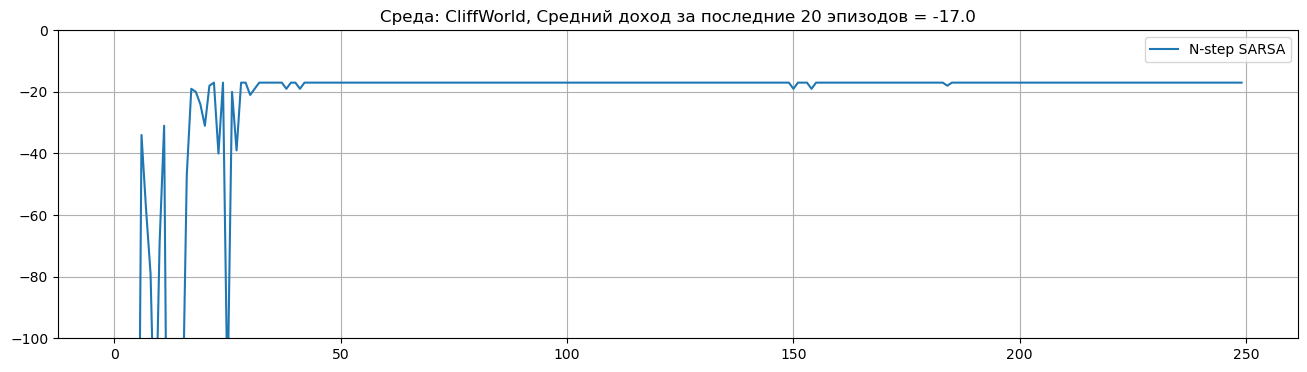

In [13]:
# график доходов
returns = np.array(env.return_queue)
plot_rewards("CliffWorld", returns, 'N-step SARSA')

Роль случайности конечно велика при обучении, но агент обучается той же стратегии, что и в обычном методе SARSA (безопасный путь длиной 17 шагов), в среднем примерно в 10 раз быстрее по сравнению с классическим SARSA.

In [15]:
import time
from IPython.display import clear_output

env = gym.make("CliffWalking-v0", render_mode='ansi')

state, _ = env.reset()
print(env.render())

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    
    time.sleep(.2)
    clear_output(wait=True)
    print(env.render())

    if terminated or truncated:
        break
    
env.close()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x




# Пример 2


Рассмотрим также работу алгоритма n-шагового SARSA на примере задачи `MountainCar`. 

Напомним особенности: 
    
    1. Цель: въехать тележкой на вершину холма (позиция 0.5)
    2. Состояние: два числа, которые дают информацию о положении и скорости тележки по оси Ox, а именно
        
        [положение, скорость]
        
Положение в интервале [-1.2,0.6], скорость в интервале [-0.07,0.07]. Старт в случайном положении от -0.6 до -0.4 с нулевой скоростью. В данном случае агенту доступно лишь наблюдение о состоянии среды, так как полная информация включала бы x-, y-координаты тележки и вектор скорости. Тем не менее доступной информации достаточно, чтобы решить задачу обучения.

    3. Действия: [0,1,2], где 0 толкнуть влево, 1 не толкать, 2 толкнуть вправо.
    4. Вознаграждение: -1 за каждый временной шаг.
    5. Завершение: либо достижение вершины холма, либо достигнут максимум в 200 временных шагов.      

In [17]:
env = gym.make('MountainCar-v0')
state, _ = env.reset()
print("Начальное состояние: ", state)

Начальное состояние:  [-0.5690471  0.       ]


In [19]:
env = gym.make('MountainCar-v0', render_mode="human")
env.reset()
for _ in range(100):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
env.close()

Для дискретизации потребуется класс-обёртка.

In [21]:
from gymnasium.wrappers import TransformObservation

# Вычислим шаг дискретизации
lower_bounds = env.observation_space.low
upper_bounds = env.observation_space.high
discrete_step = (upper_bounds - lower_bounds)/[20, 20]        
    
def modifyObs(obs):
    return tuple(np.int8((obs - lower_bounds)/discrete_step))

In [23]:
env = gym.make('MountainCar-v0')
env = TransformObservation(env, modifyObs, None)

# проверка работы: напечатаем первые 5 состояний
env.reset()
for _ in range(5):
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    print(state)

env.close()

(7, 10)
(7, 10)
(7, 9)
(7, 9)
(7, 9)


In [25]:
# Создание среды c обёрткой
env = gym.make('MountainCar-v0', max_episode_steps = 5000)
env = TransformObservation(env, modifyObs, None)
n_episodes = 1000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env)

# обучение агента и получение доходов по эпизодам
SARSA_Nstep_control(env, agent, n_episodes = n_episodes, gamma=0.99, 
                            eps_start=1.0, eps_decay = 0.995, eps_min = 0.001,
                       alpha_start=0.5, alpha_decay = 0.95,  alpha_min = 0.05, nstep=10)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.53it/s]


Сначала обучению идёт очень медленно, так как при случайных действиях мала вероятность попасть на вершину холма. Первый успех возникает уже около 200 эпизода обучения. Затем обучение идёт гораздо быстрее.

In [27]:
print(agent.alpha)
print(agent.eps)

0.05
0.006653968578831948


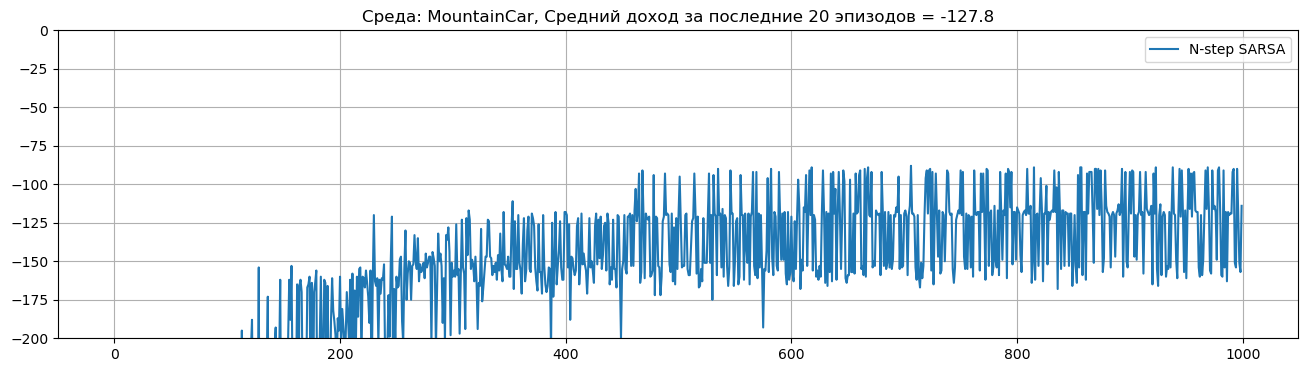

In [31]:
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-200, 0)
    plt.show()

# график доходов
returns = np.array(env.return_queue)
plot_rewards("MountainCar", returns, 'N-step SARSA')

In [44]:
#save_Q(agent, 'MountCar_by_NstepSARSA_1K')
load_Q(agent, 'savedModels/MountCar_by_NstepSARSA_1K.pkl')

Снова, по сравнению с 1-шаговыми методами, агенту потребовалось меньше эпизодов, чтобы достичь стратегии, гарантирующей достижение цели, хотя эта стратегия не оптимальна (лучший вариант - это среднее порядка 110 шагов).

In [33]:
# создание экземпляра среды
env = gym.make('MountainCar-v0')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env, n_episodes)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 285.24it/s]

Средний доход:  -126.84
Минимальный доход:  -166.0


Ниже можно запустить демонстрацию работы агента.

In [51]:
# создание экземпляра среды
env = gym.make('MountainCar-v0', render_mode='human')
env = TransformObservation(env, modifyObs, None)
env = gym.wrappers.RecordEpisodeStatistics(env)

agent.play(env, 1)

print("Число шагов:", env.length_queue[-1])
# завершить взаимодействие со средой
env.close()

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.89s/it]

Число шагов: 113


### Задача

Обучить агента одним из изученных выше методов взаимодействию со средой 

    env = gym.make("Acrobot-v1")

Базовое описание среды можно найти по ссылке:

    https://gymnasium.farama.org/environments/classic_control/acrobot/

Цель в обучении агента, чтобы при прогоне на 1000 эпизодах средний доход превысил -105. 

Можно удвоить ценность задачи, если средний доход превысит -85.

In [9]:
import gymnasium as gym
# Создание среды
env = gym.make("Acrobot-v1", render_mode = 'human')

agent = TableAgent(env)

state, _ = env.reset()
while True:
    # выбираем лучшие действия
    action = env.action_space.sample()
    state, reward, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break

In [45]:
def modifyObs(obs):
    ????

# Создание среды c обёрткой
env = gym.make("Acrobot-v1")
env = TransformObservation(env, modifyObs, None)
n_episodes = 1000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)
agent = TableAgent(env)

In [51]:
# создание экземпляра среды
env = gym.make('Acrobot-v1')
env = TransformObservation(env, modifyObs, None)
n_episodes = 1000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

agent.play(env, n_episodes)

print("Средний доход: ", np.mean(env.return_queue))
print("Минимальный доход: ", np.min(env.return_queue))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.21it/s]

Средний доход:  -85.735
Минимальный доход:  -186.0


In [11]:
env.close()